In [3]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../')

# Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display

from pyvis.network import Network

import pickle
import os

import math
from mpl_toolkits.axes_grid1 import make_axes_locatable


np.random.seed(42)
datasets = f'../data/connectomes/'
#already_done = os.listdir('../images/imgs_connectomes/') 
#excluded = ['c.elegans.herm_pharynx_1.graphml']
#already_done = [os.path.splitext(file)[0] for file in already_done] + excluded

connectomes = sorted(os.listdir(datasets)) 
#connectomes = [connectome for connectome in connectomes if connectome not in already_done]
print(connectomes)

# Ensure the necessary directories exist
os.makedirs('../images/imgs_connectomes_spectra_kde/', exist_ok=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['c.elegans.herm_pharynx_1.graphml', 'c.elegans_neural.male_1.graphml', 'drosophila_medulla_1.graphml', 'kasthuri_graph_v4.graphml', 'mixed.species_brain_1.graphml', 'mouse_brain_1.graphml', 'mouse_retina_1.graphml', 'mouse_visual.cortex_1.graphml', 'mouse_visual.cortex_2.graphml', 'p.pacificus_neural.synaptic_1.graphml', 'p.pacificus_neural.synaptic_2.graphml', 'rattus.norvegicus_brain_1.graphml', 'rattus.norvegicus_brain_2.graphml', 'rattus.norvegicus_brain_3.graphml', 'rhesus_brain_1.graphml', 'rhesus_brain_2.graphml', 'rhesus_cerebral.cortex_1.graphml', 'rhesus_interareal.cortical.network_2.graphml']


In [4]:
def get_logit_graph(real_graph, d, n_iteration, warm_up, patience, dist_type='KL'):
   # Ensure real_graph is a NumPy array
   if isinstance(real_graph, nx.Graph):
       real_graph = nx.to_numpy_array(real_graph)
   
   # Estimation
   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   # Generation
   n = real_graph.shape[0]

   # TODO: improve the estimation of d
   # d=0

   params_dict = {
      "n": n,
      "d": d,
      "sigma": sigma,
      "n_iteration": n_iteration,
      "warm_up": warm_up
   }

   graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)
   graphs, spec, spectrum_diffs, best_iteration = graph_model.populate_edges_spectrum(
       warm_up=warm_up,
       max_iterations=n_iteration,
       patience=patience,  # You may want to adjust this value
       real_graph=real_graph
   )

   # Add early stopping condition
   if len(spectrum_diffs) > 10000 and all(abs(spectrum_diffs[-1] - sd) < 1e-6 for sd in spectrum_diffs[-10000:]):
       print("Early stopping: No significant improvement in the last 1000 iterations.")
       best_iteration = len(spectrum_diffs) - 10000

   # Use the best graph found
   best_graph = graphs[best_iteration]
   # Calculate GIC for the best graph
   best_graph_nx = nx.from_numpy_array(best_graph)
   gic_value = gic.GraphInformationCriterion(
       graph=nx.from_numpy_array(real_graph),
       log_graph=best_graph_nx,
       model='LG',
       dist_type=dist_type # KL or L1 or L2
   ).calculate_gic()
   
   gic_values = [gic_value]
   return best_graph, sigma, gic_values, spectrum_diffs, best_iteration, graphs

def clean_and_convert(param):
    cleaned_param = ''.join(c for c in param if c.isdigit() or c == '.' or c == '-')
    return float(cleaned_param)

def plot_graphs_in_matrix(sim_graphs_dict, result_dict, global_title, save_path=None):
    num_graphs = len(sim_graphs_dict)
    cols = min(4, num_graphs)  # Limit to 4 columns max
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, (name, G) in zip(axes, sim_graphs_dict.items()):
        # Use force-directed layout for better distribution of nodes
        pos = nx.spring_layout(G, k=0.5, iterations=50)

        # Normalize node sizes and reduce
        degrees = dict(G.degree())
        max_degree = max(degrees.values())
        min_degree = min(degrees.values())
        node_sizes = [((degrees[node] - min_degree) / (max_degree - min_degree + 1e-6)) * 100 + 10 for node in G.nodes()]

        # Normalize node colors
        node_color = list(degrees.values())

        # Draw edges first
        edge_color = 'lightgray'
        alpha = 1
        width = 0.8
        if G.number_of_edges() > 1000:
            # For dense graphs, sample a subset of edges
            edges = list(G.edges())
            sampled_edges = np.random.choice(len(edges), size=1000, replace=False)
            edges = [edges[i] for i in sampled_edges]
            nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_color, alpha=alpha, width=width, ax=ax)
        else:
            nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=alpha, width=width, ax=ax)

        # Draw nodes on top of edges
        scatter = nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_sizes, 
                                         cmap=plt.cm.viridis, ax=ax, alpha=0.8)

        # Set plot details
        if name != 'Real':
            ax.set_title(f'{name} Graph\nGIC: {result_dict[name]["GIC"]:.4f}', fontsize=10)
        else:
            ax.set_title(f'{name} Graph', fontsize=10)
        ax.axis('off')

        # Add a colorbar to show degree scale
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scatter, cax=cax)
        cbar.set_label('Node Degree', fontsize=8)
        cbar.ax.tick_params(labelsize=6)

    # Hide unused axes
    for i in range(len(sim_graphs_dict), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(global_title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    #plt.show()
    return fig

def plot_spectra_in_matrix(sim_graphs_dict, result_dict, global_title, bins=120, save_path=None):
    num_graphs = len(sim_graphs_dict)
    cols = min(4, num_graphs)  # Limit to 4 columns max
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, (name, G) in zip(axes, sim_graphs_dict.items()):
        # Calculate the spectrum (eigenvalues) of the graph
        laplacian = nx.normalized_laplacian_matrix(G)
        eigenvalues = np.linalg.eigvals(laplacian.toarray())
        eigenvalues = np.real(eigenvalues)  # Take only the real part

        # Plot histogram of eigenvalues
        ax.hist(eigenvalues, bins=bins, density=True, alpha=0.7, color='skyblue')

        # Calculate and plot KDE
        kde = stats.gaussian_kde(eigenvalues)
        x_range = np.linspace(min(eigenvalues), max(eigenvalues), 200)
        ax.plot(x_range, kde(x_range), 'r-', lw=2)

        # Set plot details
        if name != 'Real':
            ax.set_title(f'{name} Graph Spectrum\nGIC: {result_dict[name]["GIC"]:.4f}', fontsize=15)
        else:
            ax.set_title(f'{name} Graph Spectrum', fontsize=15)
        ax.set_xlabel('Eigenvalue', fontsize=8)
        ax.set_ylabel('Density', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=10)

        # Add text with graph properties
        props = f"Nodes: {G.number_of_nodes()}\nEdges: {G.number_of_edges()}"
        ax.text(0.95, 0.95, props, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Hide unused axes
    for i in range(len(sim_graphs_dict), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(global_title, fontsize=20, fontweight='bold')
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    #plt.show()
    return fig



In [6]:
def analyze_connectome_spectrum(connectome_filename, n_bootstrap=1000, warm_up=1000, n_iteration=100, patience=10):
    """
    Analyze a single connectome file and generate KDE data with confidence intervals.
    
    Args:
        connectome_filename (str): Name of the connectome file
        n_bootstrap (int): Number of bootstrap samples for confidence intervals
        
    Returns:
        dict: Contains plot data for each model including:
            - x_range: x-axis values
            - mean_curve: mean KDE curve
            - lower_ci: lower confidence interval
            - upper_ci: upper confidence interval
            - model_info: model parameters and metrics
        str: Clean title for plotting
    """
    # Read and process the graph
    real_graph = nx.read_graphml(datasets + connectome_filename)
    real_graph = nx.to_numpy_array(real_graph)
    
    # Get the logit graph results (using the best d=2 for simplicity)
    logit_graph, sigma, gic_values, spectrum_diffs, best_iteration, all_graphs = get_logit_graph(
        real_graph=nx.from_numpy_array(real_graph),
        d=0,
        warm_up=warm_up,
        n_iteration=n_iteration,
        patience=patience,
        dist_type='KL'
    )
    
    # Setup model selection
    n_runs_graphs = 5
    all_graphs_lg = all_graphs[-n_runs_graphs-1:-1]
    all_graphs_lg = [nx.from_numpy_array(graph) for graph in all_graphs_lg]
    log_params = [sigma]*len(all_graphs_lg)
    
    selector = ms.GraphModelSelection(
        graph=nx.from_numpy_array(real_graph),
        log_graphs=all_graphs_lg,
        log_params=log_params,
        models=["ER", "WS", "GRG", "BA", "LG"],
        n_runs=n_runs_graphs,
        parameters=[
            {'lo': 0.01, 'hi': 1},  # ER
            {'lo': 0.01, 'hi': 1},  # WS k=8
            {'lo': 1, 'hi': 3},     # GRG
            {'lo': 1, 'hi': 5},     # BA
        ]
    )
    
    result = selector.select_model_avg_spectrum()
    result_dict = {item['model']: {'param': clean_and_convert(item['param']), 
                                  'distance': item['distance'], 
                                  'GIC': item['GIC']} 
                  for item in result['estimates']}
    
    # Generate graphs for each model
    sim_graphs_dict = {}
    for model in result_dict.keys():
        if model != 'LG':
            func = selector.model_function(model_name=model)
            graph_sim = func(real_graph.shape[0], float(result_dict[model]['param']))
            sim_graphs_dict[model] = graph_sim
        elif model == 'LG':
            sim_graphs_dict[model] = nx.from_numpy_array(logit_graph)
    sim_graphs_dict['Real'] = nx.from_numpy_array(real_graph)
    
    # Calculate KDE data with confidence intervals
    plot_data = {}
    
    for name, G in sim_graphs_dict.items():
        # Calculate eigenvalues
        laplacian = nx.normalized_laplacian_matrix(G)
        eigenvalues = np.real(np.linalg.eigvals(laplacian.toarray()))
        
        # Bootstrap for confidence intervals
        kde_curves = []
        x_range = np.linspace(min(eigenvalues), max(eigenvalues), 200)
        
        for _ in range(n_bootstrap):
            boot_sample = np.random.choice(eigenvalues, size=len(eigenvalues), replace=True)
            kde = gaussian_kde(boot_sample)
            kde_curves.append(kde(x_range))
            
        # Calculate confidence intervals
        kde_curves = np.array(kde_curves)
        mean_curve = np.mean(kde_curves, axis=0)
        lower_ci = np.percentile(kde_curves, 2.5, axis=0)
        upper_ci = np.percentile(kde_curves, 97.5, axis=0)
        
        plot_data[name] = {
            'x_range': x_range,
            'mean_curve': mean_curve,
            'lower_ci': lower_ci,
            'upper_ci': upper_ci,
            'model_info': result_dict.get(name, {})
        }
    
    # Generate clean title
    clean_title = os.path.splitext(connectome_filename)[0].replace('_', ' ')
    clean_title = clean_title.replace('.', ' ')
    clean_title = ' '.join(word.capitalize() for word in clean_title.split())
    
    return plot_data, clean_title


In [7]:
def plot_spectral_density_kde(results, model_families):
    """
    Plot spectral density with confidence intervals for different network models.
    
    Args:
        results: Tuple containing plot data dictionary and title string
    """
    import seaborn as sns
    # change the style
    sns.set_style("whitegrid")

    # Create the plot
    plt.figure(figsize=(12, 8))

    for name, data in results[0].items():
        if name in model_families:  # Only plot if model is in model_families
            label = model_families[name]  # Use full name from model_families
            plt.plot(data['x_range'], data['mean_curve'], label=label, linewidth=2)
            plt.fill_between(data['x_range'],
                           data['lower_ci'],
                           data['upper_ci'], 
                           alpha=0.2)

    plt.title(f'Spectral Density with 95% Confidence Intervals\n{results[1]}')
    plt.xlabel('Eigenvalue')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 10)
    plt.show()


In [8]:
# Good indexes
i = 1
connectome_file = connectomes[i]  # or specify your file
print(connectome_file)

c.elegans_neural.male_1.graphml


In [18]:
# ----- Simulation Section -----
warm_up = 3000
n_iteration = 3000
patience = 10

# Specify the number of connectomes to simulate
n_connectomes = 1
n_bootstrap = 10
simulation_results = []

# Iterate through connectomes to perform simulations and save results
for idx, connectome_file in enumerate(connectomes):
    if idx == n_connectomes:
        break
    # Run the simulation analysis for the current connectome
    results = analyze_connectome_spectrum(connectome_file, n_bootstrap=n_bootstrap, 
                                          warm_up=warm_up, n_iteration=n_iteration, 
                                          patience=patience)
    
    # Save the simulation result to a pickle file
    import pickle
    with open(f'../images/imgs_connectomes_spectra_kde/results_{connectome_file}.pkl', 'wb') as f:
        pickle.dump(results, f)
    
    # Store results along with the connectome file name for plotting
    simulation_results.append((connectome_file, results))


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-09 22:41 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

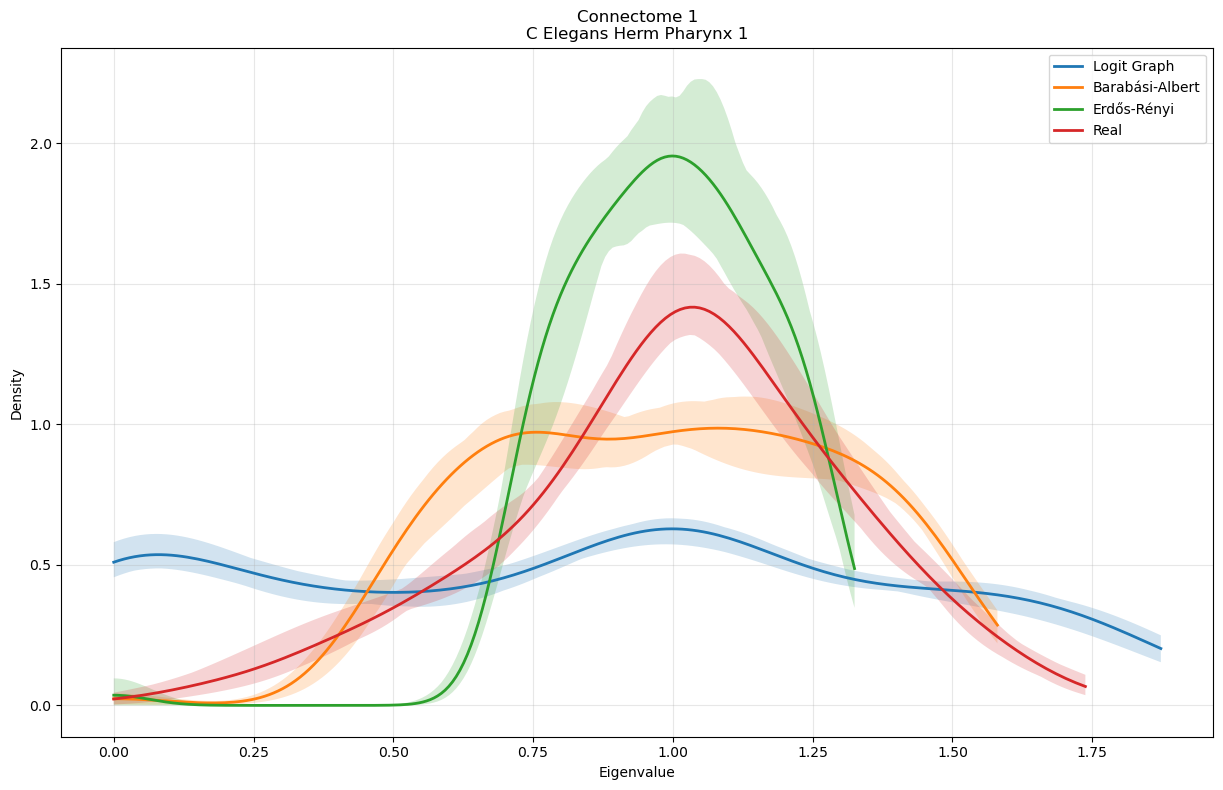

In [20]:
# ----- Plotting Section -----
n_cols = 2  # You can adjust this as needed
n_rows = (n_connectomes + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 8 * n_rows))
axes = axes.flatten()

model_families = {
    'ER': 'Erdős-Rényi',
    #'GRG': 'Random Geometric', 
    #'KR': 'Regular Random',
    #'WS': 'Watts-Strogatz',
    'BA': 'Barabási-Albert',
    'LG': 'Logit Graph',
    'Real': 'Real'
}

# Plot each simulation result on its corresponding subplot
for idx, (connectome_file, results) in enumerate(simulation_results):
    ax = axes[idx]
    for name, data in results[0].items():
        if name in model_families:
            label = model_families[name]
            ax.plot(data['x_range'], data['mean_curve'], label=label, linewidth=2)
            ax.fill_between(data['x_range'],
                            data['lower_ci'],
                            data['upper_ci'],
                            alpha=0.2)
    
    ax.set_title(f'Connectome {idx + 1}\n{results[1]}')
    ax.set_xlabel('Eigenvalue')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove any unused subplots if there are more axes than results
for idx in range(len(simulation_results), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Save the final figure
fig.savefig(f'../images/imgs_connectomes_spectra_kde/spectra_kde_n_{n_connectomes}.png', bbox_inches='tight', dpi=300)
